In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS 340W/12 (2) (Data).csv")
print(data.head(0))
data = data.loc[:,['date','high','low','open','Volume XRP','Volume USDT','close']]
print(data.head(5))
print(data.date)

Empty DataFrame
Columns: [unix, date, symbol, open, high, low, close, Volume XRP, Volume USDT]
Index: []
         date    high     low    open   Volume XRP   Volume USDT   close
0  12-27-2021  0.9237  0.9200  0.9200    2384512.0  2.198450e+06  0.9226
1  12-26-2021  0.9334  0.9052  0.9252  163438501.0  1.499400e+08  0.9200
2  12-25-2021  0.9350  0.8981  0.9114  250074945.0  2.302303e+08  0.9252
3  12-24-2021  0.9966  0.8964  0.9941  567234092.0  5.377035e+08  0.9115
4  12-23-2021  1.0167  0.9372  0.9538  479436230.0  4.729372e+08  0.9941
0       12-27-2021
1       12-26-2021
2       12-25-2021
3       12-24-2021
4       12-23-2021
           ...    
1329      5-8-2018
1330      5-7-2018
1331      5-6-2018
1332      5-5-2018
1333      5-4-2018
Name: date, Length: 1334, dtype: object


In [4]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2021-12-27', '2021-12-26', '2021-12-25', '2021-12-24',
               '2021-12-23', '2021-12-22', '2021-12-21', '2021-12-20',
               '2021-12-19', '2021-12-18',
               ...
               '2018-05-13', '2018-05-12', '2018-05-11', '2018-05-10',
               '2018-05-09', '2018-05-08', '2018-05-07', '2018-05-06',
               '2018-05-05', '2018-05-04'],
              dtype='datetime64[ns]', name='date', length=1334, freq=None)


In [5]:
aim = 'close'

In [6]:


train_data = data.iloc[200:]
test_data = data.iloc[:200]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

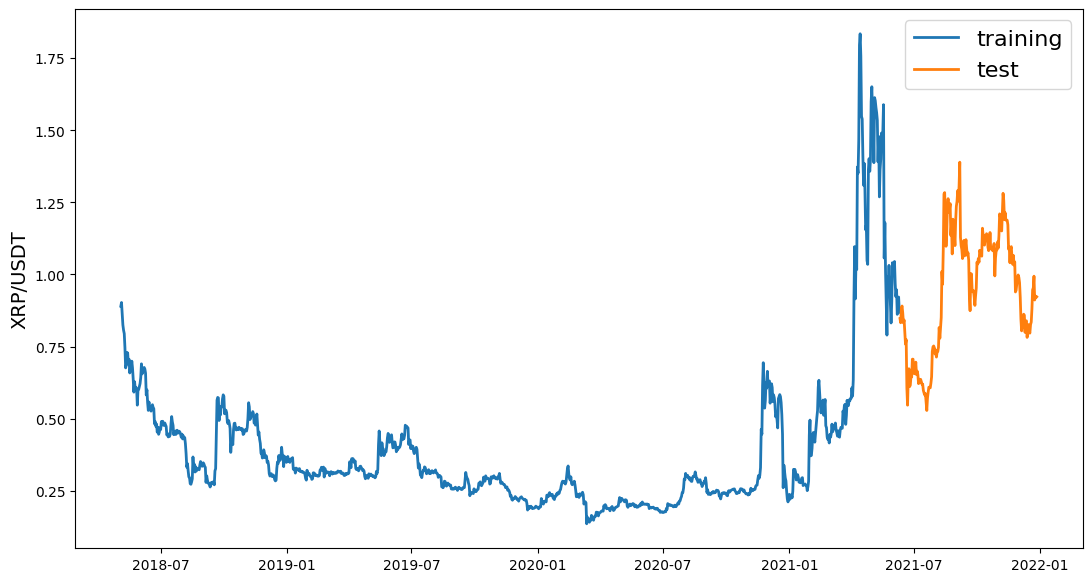

In [7]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [8]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [9]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test
import numpy as np

In [10]:
from tensorflow.keras import layers

In [11]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [12]:
print(X_train.shape)

(1129, 5, 6)


In [13]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0159 - val_loss: 0.0042
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_l

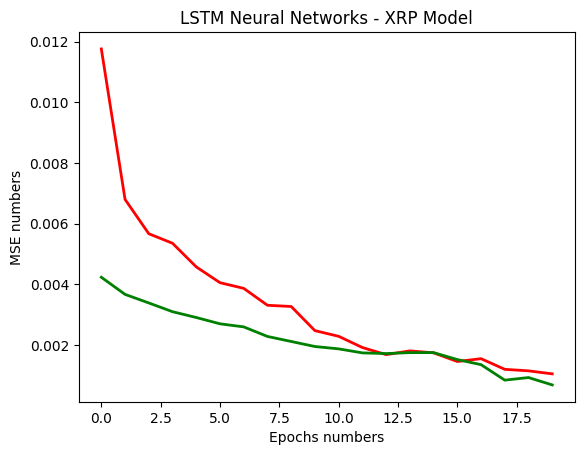

In [14]:
import matplotlib.pyplot as plt
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [15]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


0.018515415593927012

In [16]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.000678542292538913

In [17]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

94.74931517675329

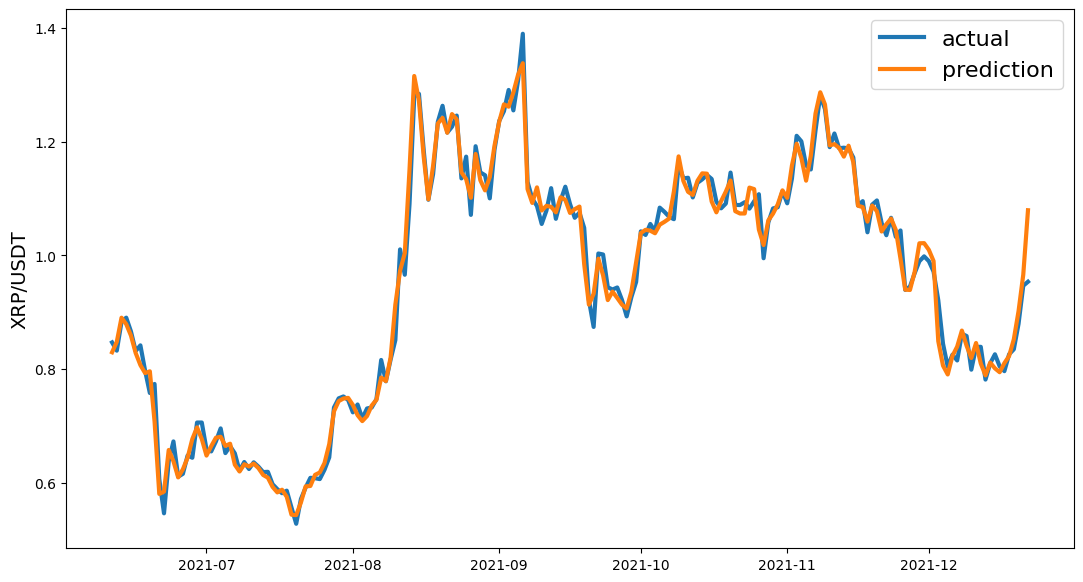

In [18]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)